In [1]:
import importlib

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.nn import MSELoss
from torch import optim
import matplotlib.pyplot as plt
import Frenel_Holo
importlib.reload(Frenel_Holo)
import numpy as np
import time
import os


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
) 

In [61]:
class HologramDataset(Dataset):
    def __init__(self,  training_dataset, N, ps, wavelength, transform = None):
        self.N = N
        self.ps = ps
        self.wavelength = wavelength
        self.training_data = training_dataset.data
        self.z_0 = self.N * self.ps * self.ps / self.wavelength
        self.transform = transform
    def __getitem__(self, index):
        image = self.training_data[index]
        phase = np.random.uniform(0, 2*np.pi, image.shape)
        object_field = np.zeros((self.N, self.N), dtype = complex)
        object_field[0 : image.shape[1], 0 : image.shape[1]] = np.sqrt(image) * np.exp(1j * phase)
        y,x,y_fren = Frenel_Holo.FullReconstruct(object_field, 6*self.z_0, plotting=False)
        if self.transform:
            return self.transform(y), self.transform(x), self.transform(y_fren)
        return y[None], x[None], y_fren[None]
    def __len__(self):
        return len(self.training_data)
    

In [63]:
transformer = transforms.Compose([
    transforms.ToTensor(), # converting to tensors
    #transforms.Resize((SIZE_H, SIZE_W),),
    # scaling images to fixed size
    #transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])
N = 64
ps = 5.5*1e-6
wavelength = 532e-9 
z_0 = N * ps * ps / wavelength
holo_train_dataset = HologramDataset(training_data, N, ps, wavelength, transform = None)
holo_val_dataset = HologramDataset(validation_data, N, ps, wavelength, transform = None)

In [64]:
train_loader = DataLoader(holo_train_dataset, batch_size = 128)
val_loader = DataLoader(holo_val_dataset, batch_size = 128)


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SAVE_DIR = r'Weights//UNet'

In [7]:
def train_model(model, train_dataset, val_dataset, opt, loss_func, bs = 10, n_epochs = 20):
    train_loader = DataLoader(train_dataset, bs)
    val_loader = DataLoader(val_dataset, bs)
    epoch_train_loss = []
    epoch_val_loss = []
    for epoch in range(n_epochs):
        start_time = time.time()
        batch_train_loss = []
        batch_val_loss = []
        model.train(True) # Enable Dropout/BatchNorm trainig behavior
        i=0
        for y_batch, x_batch, _ in train_loader:
            opt.zero_grad()
            x_batch = x_batch.to(device).to(torch.float)
            y_batch = y_batch.to(device).to(torch.float)
            predictions = model(x_batch)
            loss = loss_func()(predictions, y_batch)
            loss.backward()
            batch_train_loss.append(loss.item())
            opt.step()
            i+=1
            if i%10 == 0:
                print('Batch ', i)
        model.train(False)
        i = 0
        with torch.no_grad():
            for y_batch, x_batch, _ in val_loader:
                x_batch = x_batch.to(device).to(torch.float)
                y_batch = y_batch.to(device).to(torch.float)
                predictions = model(x_batch)
                loss = loss_func()(predictions, y_batch)
                batch_val_loss.append(loss)
                i+=1
                if i%10 == 0:
                    print('Batch ', i)
        epoch_train_loss.append(torch.mean(torch.Tensor(batch_train_loss)))
        epoch_val_loss.append(torch.mean(torch.Tensor(batch_val_loss)))
        
        path = os.path.join(SAVE_DIR, f'{model.__class__.__name__}_epoch{epoch+1}.pth')
        torch.save(model.cpu().state_dict(), path)
        model.cuda()
        
        print(f'Epoch {epoch+1} of {n_epochs} took {time.time() - start_time:.3f} s')
        print(f"\t  training loss: {epoch_train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {epoch_val_loss[-1]:.6f}")
    return epoch_train_loss, epoch_val_loss

In [ ]:

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=64,)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001,)

In [8]:
from my_unet import UNet
my_unet = UNet(1,1,64)
my_unet.to(device)
optimizer = optim.Adam(my_unet.parameters(), lr=0.001,)

In [9]:
unet_train_loss, unet_val_loss = train_model(my_unet, holo_train_dataset, holo_val_dataset,
                                                 optimizer, MSELoss, 64, 10)

Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90
Batch  100
Batch  110
Batch  120
Batch  130
Batch  140
Batch  150
Batch  160
Batch  170
Batch  180
Batch  190
Batch  200
Batch  210
Batch  220
Batch  230
Batch  240
Batch  250
Batch  260
Batch  270
Batch  280
Batch  290
Batch  300
Batch  310
Batch  320
Batch  330
Batch  340
Batch  350
Batch  360
Batch  370
Batch  380
Batch  390
Batch  400
Batch  410
Batch  420
Batch  430
Batch  440
Batch  450
Batch  460
Batch  470
Batch  480
Batch  490
Batch  500
Batch  510
Batch  520
Batch  530
Batch  540
Batch  550
Batch  560
Batch  570
Batch  580
Batch  590
Batch  600
Batch  610
Batch  620
Batch  630
Batch  640
Batch  650
Batch  660
Batch  670
Batch  680
Batch  690
Batch  700
Batch  710
Batch  720
Batch  730
Batch  740
Batch  750
Batch  760
Batch  770
Batch  780
Batch  790
Batch  800
Batch  810
Batch  820
Batch  830
Batch  840
Batch  850
Batch  860
Batch  870
Batch  880
Batch  890
Batch  900
Batch  910
Batch  9

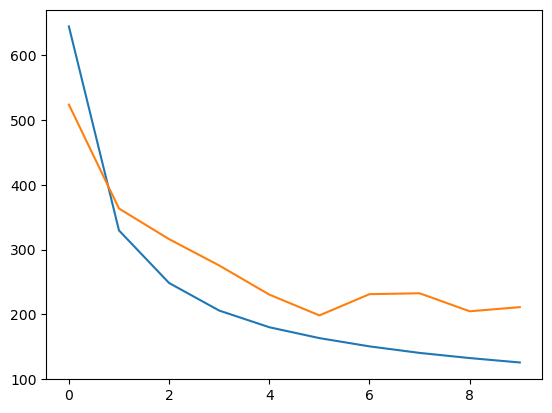

In [11]:
plt.plot(unet_train_loss)
plt.plot(unet_val_loss)

In [14]:
best_model = UNet(1,1,64)
best_model.to(device)
best_model.load_state_dict(torch.load(SAVE_DIR + '//UNet_epoch6.pth'))
best_model.eval()

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d

Text(0.5, 1.0, 'Восстановленное Френелем')

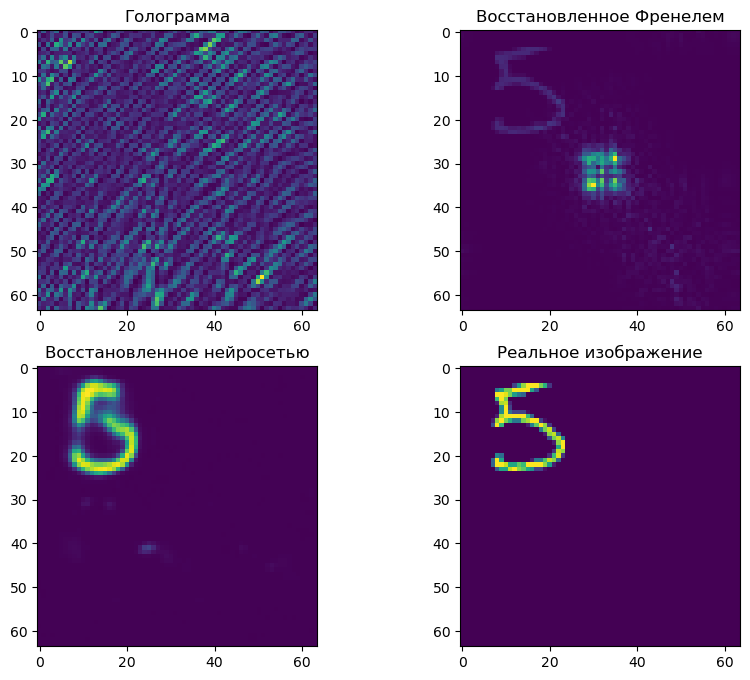

In [67]:
N_image = 15
y,x,y_fren = next(iter(val_loader))
x = x.to(device).to(torch.float)
fig, ax = plt.subplots(2,2, figsize = (10,8))

ax[1,0].imshow(best_model(x[N_image:N_image+1])[0][0].cpu().detach().numpy())
ax[1,0].set_title('Восстановленное нейросетью')
ax[0,0].imshow(x[N_image][0].cpu())
ax[0,0].set_title('Голограмма')
ax[1,1].imshow(y[N_image][0])
ax[1,1].set_title('Реальное изображение')
ax[0,1].imshow(y_fren[N_image][0])
ax[0,1].set_title('Восстановленное Френелем')

In [39]:
y.shape

torch.Size([128, 1, 64, 64])

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')